# Trading with Momentum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
import yfinance as yf

In [2]:
tickers_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers_data.loc[:,'Symbol'] = tickers_data.loc[:,'Symbol'].apply(lambda x:str(x).replace('.', '-' ))
tickers_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
start = '2011-01-01'
end = '2016-01-01'

In [4]:
tickers = yf.Tickers(list(tickers_data.loc[:,'Symbol']))

data = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
data = data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


20 Failed downloads:
['ABNB', 'CARR', 'IR', 'KVUE', 'GEHC', 'DOW', 'MRNA', 'FOXA', 'FTV', 'VLTO', 'CEG', 'CDAY', 'LW', 'UBER', 'INVH', 'FOX', 'VICI', 'CTVA', 'OTIS', 'HWM']: Exception("%ticker%: Data doesn't exist for startDate = 1293858000, endDate = 1451624400")


,Ticker,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume,Date
0,A,27.013271,29.957083,0.0,30.143063,29.620888,29.728184,0.0,4994075.0,2011-01-03
1,AAL,10.040195,10.650000,0.0,10.710000,10.080000,10.110000,0.0,7465800.0,2011-01-03
2,AAPL,9.977495,11.770357,0.0,11.795000,11.601429,11.630000,0.0,445138400.0,2011-01-03
3,ABT,17.371452,22.944036,0.0,23.169542,22.920046,23.169542,0.0,19050229.0,2011-01-03
4,ACGL,9.832222,9.832222,0.0,9.855556,9.778889,9.855556,0.0,4016700.0,2011-01-03


In [5]:
_open = data.pivot(index='Date', columns='Ticker', values='Open')
_open = _open.dropna(axis=1)
_open.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.728184,10.11,11.630000,23.169542,9.855556,48.660000,30.830000,37.680000,30.389999,41.044777,...,92.000000,19.209999,106.250000,23.670000,73.720001,34.459999,35.442127,52.524273,38.270000,24.740000
2011-01-04,30.035765,10.73,11.872857,23.049591,9.860000,48.750000,31.280001,38.200001,30.440001,41.229149,...,92.344368,19.900000,109.410004,23.610001,74.709999,35.070000,35.283970,53.359222,38.480000,25.250000
2011-01-05,29.513592,10.74,11.769643,23.135956,9.736667,48.139999,31.480000,37.430000,30.500000,41.150131,...,91.311256,19.500000,111.550003,23.590000,74.669998,34.639999,34.601006,52.407768,37.639999,24.309999
2011-01-06,29.592276,11.15,11.954286,23.270300,9.642222,48.180000,32.130001,37.750000,31.070000,41.738365,...,92.768211,20.219999,113.919998,23.350000,74.900002,34.930000,35.190510,52.446602,37.880001,24.830000
2011-01-07,29.699572,11.20,11.928214,23.097572,9.652222,48.369999,32.180000,37.939999,31.950001,41.922737,...,93.059601,20.190001,115.660004,23.520000,75.209999,34.950001,35.233646,51.213593,37.470001,24.889999


In [6]:
_adj_close = data.pivot(index='Date', columns='Ticker', values='Adj Close')
_adj_close = _adj_close.dropna(axis=1)
_adj_close.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.013271,10.040195,9.977495,17.371452,9.832222,38.189999,31.290001,27.901520,21.699984,30.504313,...,72.243698,12.183902,77.028137,15.394320,44.966911,31.863161,27.514250,48.349281,38.200001,20.047049
2011-01-04,26.761717,10.011915,10.029565,17.534927,9.771111,37.938488,31.510000,27.585375,21.685709,30.394077,...,71.031395,12.054416,79.431053,15.459669,45.178032,31.509123,27.093885,47.707191,37.840000,19.720495
2011-01-05,26.703659,10.464429,10.111607,17.534927,9.785556,37.946346,32.220001,27.644184,21.785639,30.880333,...,72.017647,12.430538,80.455841,15.368184,45.057373,31.808685,27.222799,47.742386,37.799999,19.832006
2011-01-06,26.755272,10.596414,10.103436,17.498596,9.653333,38.087822,32.270000,27.798594,22.620806,31.120224,...,72.223137,12.344216,81.042442,15.355116,45.346905,31.627132,27.413363,46.264725,37.480000,19.776255
2011-01-07,26.845572,10.747252,10.175791,17.571255,9.580000,38.150692,32.040001,27.636831,22.806395,31.191549,...,72.099861,12.683343,83.911850,15.492332,45.594215,31.500055,27.755262,46.255932,37.599998,19.569162


-----

In [6]:
tickers.tickers['AAPL'].info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

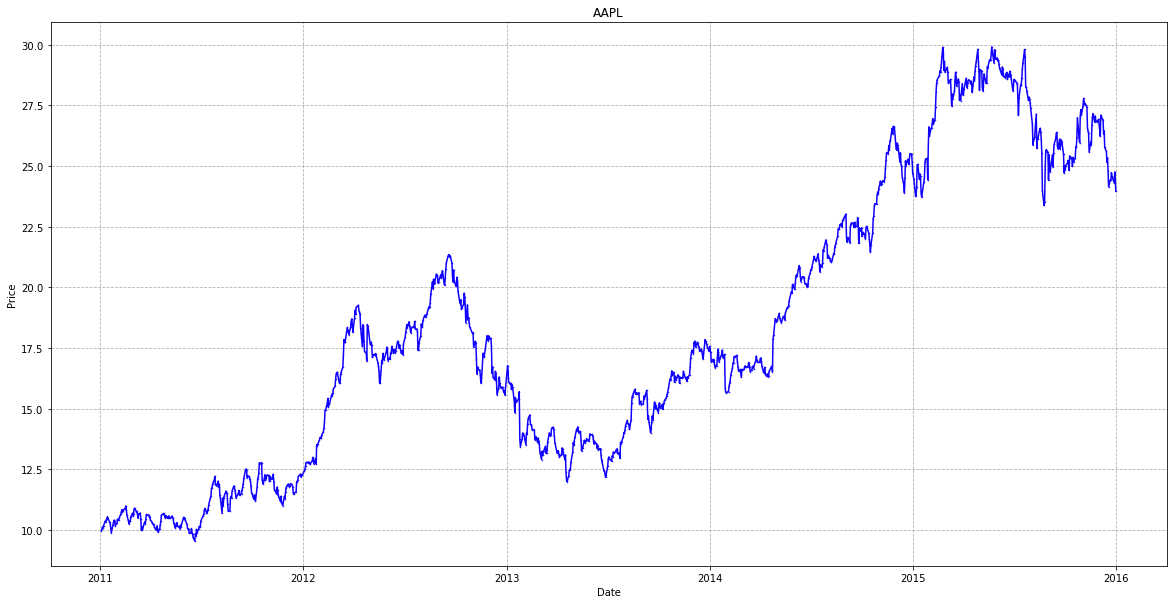

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('AAPL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.plot(_adj_close.index, _adj_close.loc[:,['AAPL']].values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

-----

In [16]:
returns = ((_adj_close - _adj_close.shift(1))/_adj_close.shift(1)).iloc[1:,:]
returns.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,-0.009312,-0.002817,0.005219,0.009411,-0.006215,-0.006586,0.007031,-0.011331,-0.000658,-0.003614,...,-0.016781,-0.010628,0.031195,0.004245,0.004695,-0.011111,-0.015278,-0.013280,-0.009424,-0.016289
2011-01-05,-0.002169,0.045198,0.008180,0.000000,0.001478,0.000207,0.022533,0.002132,0.004608,0.015998,...,0.013885,0.031202,0.012902,-0.005918,-0.002671,0.009507,0.004758,0.000738,-0.001057,0.005655
2011-01-06,0.001933,0.012613,-0.000808,-0.002072,-0.013512,0.003728,0.001552,0.005586,0.038336,0.007768,...,0.002853,-0.006944,0.007291,-0.000850,0.006426,-0.005708,0.007000,-0.030951,-0.008466,-0.002811
2011-01-07,0.003375,0.014235,0.007161,0.004152,-0.007597,0.001651,-0.007127,-0.005819,0.008204,0.002292,...,-0.001707,0.027473,0.035406,0.008936,0.005454,-0.004018,0.012472,-0.000190,0.003202,-0.010472
2011-01-10,0.014416,0.006141,0.018833,-0.008890,-0.003363,-0.008859,0.028714,0.002927,0.004382,0.000416,...,0.002565,0.011181,-0.000253,-0.006326,-0.006086,0.010374,0.001414,0.007796,0.002926,-0.017908


-----

In [17]:
def momentum(signals, window_length):
    return ((signals - signals.shift(window_length))/signals.shift(window_length)).iloc[window_length:,:]

def rank(signals, top, bottom):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        series = signals.iloc[i,:] 
        top_largest = series.nlargest(top)         
        bottom_smallest = series.nsmallest(bottom)         
        ranking = pd.concat([top_largest, bottom_smallest])
        tickers = ranking.index
        filtered_signals.iloc[i,:].loc[tickers] = 1.         
    return filtered_signals

def frequency(signals, freq):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        if i%freq==0:
            filtered_signals.iloc[i,:] = signals.iloc[i,:] 
        else:
            filtered_signals.iloc[i,:] = np.array(filtered_signals.shape[1]*[np.nan])
    filtered_signals = filtered_signals.dropna(axis=0)
    return filtered_signals

In [18]:
window_length = 50 

signals = momentum(signals=_adj_close, 
                   window_length=window_length)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-16,0.010745,-0.197183,0.001335,-0.014145,0.017064,0.008026,0.025567,-0.031716,0.137862,0.035167,...,0.105802,0.221211,0.073860,-0.008064,0.069456,-0.003989,0.041135,0.080771,-0.078534,-0.114857
2011-03-17,0.023138,-0.200565,0.010112,-0.011836,0.024903,0.015538,0.010473,0.001360,0.148860,0.047729,...,0.128146,0.251831,0.051517,-0.005495,0.089288,0.008067,0.060200,0.100848,-0.065803,-0.089695
2011-03-18,0.037198,-0.192793,-0.009970,0.001756,0.032928,0.040804,-0.007138,0.011533,0.150501,0.042649,...,0.108417,0.217446,0.023015,-0.002976,0.088034,0.004852,0.055386,0.111090,-0.048413,-0.082760
2011-03-21,0.059547,-0.184164,0.016690,0.006349,0.065723,0.039001,0.002169,0.013893,0.137183,0.046991,...,0.119203,0.259637,0.061830,0.008085,0.107696,0.025545,0.053187,0.166539,-0.010139,-0.072116
2011-03-22,0.037722,-0.219298,0.015113,0.000727,0.075853,0.037289,0.026217,0.015815,0.132959,0.047947,...,0.122257,0.198072,-0.002696,-0.000289,0.097964,0.026224,0.031486,0.155163,-0.013298,-0.047232


In [19]:
top = 10
bottom = 10 
signals = rank(signals=signals, 
               top=top, 
               bottom=bottom)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
freq = 10
signals = frequency(signals=signals, 
                    freq=freq)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

In [21]:
def optimal_portfolio(u, V, x0, risk_tolerance, turnover):
    x = cvx.Variable(u.shape[0])
    f = cvx.quad_form(x, V) - risk_tolerance*u@x + turnover*cvx.norm(x-x0, p=1) 
    prob = cvx.Problem(cvx.Minimize(f), 
                      [cvx.sum(x) == 1])
    prob.solve(solver=cvx.ECOS)
    return x.value

In [22]:
def trading_strategy(signals, returns, trading_window_length, risk_tolerance, turnover):
    portfolio_positions = pd.DataFrame(np.zeros(shape=signals.shape))
    portfolio_positions = portfolio_positions.set_index(signals.index)
    portfolio_positions.columns = signals.columns
    for i in range(signals.shape[0]):
        date = signals.index[i]
        tickers = signals.iloc[i,:].apply(lambda x:np.nan if x==0. else x).dropna().index            
        r = returns.loc[:date,:].iloc[-trading_window_length:,:].loc[:,tickers].values
        u = np.mean(r, axis=0)
        V = np.cov(r.T)  
        if i==0:
            x0 = np.ones(tickers.shape[0])/tickers.shape[0]
        else:
            x0 = portfolio_positions.iloc[i-1,:].loc[tickers].values
        x = optimal_portfolio(u, V, x0, risk_tolerance, turnover)
        if x is not None:
            portfolio_positions.loc[date,tickers] = x
        else:
            portfolio_positions.loc[date,:] = np.array(portfolio_positions.shape[1]*[np.nan])
    portfolio_positions = portfolio_positions.dropna(axis=0)
    return portfolio_positions

In [23]:
trading_window_length = 30
risk_tolerance = 0.000001
turnover = 1.

portfolio_positions = trading_strategy(signals=signals, 
                                       returns=returns, 
                                       trading_window_length=trading_window_length,
                                       risk_tolerance=risk_tolerance,
                                       turnover=turnover)
portfolio_positions.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-16,0.0,5.000000e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-30,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-13,0.0,2.822676e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-28,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-05-12,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.146907,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(121, 120.99999999946932)

-----

In [25]:
trading_prices = _open.shift(-1).loc[portfolio_positions.index,:]
trading_prices.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-16,30.851215,8.72,12.029643,22.641762,10.078889,49.630001,32.570000,37.099998,35.299999,43.134327,...,103.682121,24.559999,119.910004,23.639999,80.379997,35.430000,36.829620,58.475727,35.570000,22.770000
2011-03-30,32.131618,8.91,12.370000,23.519796,10.896667,54.810001,32.880001,39.349998,36.020000,44.899033,...,105.642387,24.500000,126.620003,23.900000,84.820000,36.610001,37.088425,58.932037,38.959999,22.969999
2011-04-13,33.097282,8.20,11.957143,24.196314,11.400000,56.110001,33.900002,37.650002,35.180000,45.531170,...,106.649010,22.340000,134.020004,23.480000,82.379997,35.860001,35.765636,57.912621,37.580002,23.700001
2011-04-28,35.979973,8.77,12.385000,25.103136,11.550000,57.060001,34.049999,40.500000,36.639999,47.506584,...,109.721855,23.910000,145.369995,24.280001,87.430000,38.230000,38.023006,64.359222,38.630001,24.600000
2011-05-12,38.676682,9.64,12.345000,25.635714,11.646667,56.459999,35.750000,41.400002,32.250000,47.822651,...,108.476822,22.090000,147.229996,24.850000,81.290001,39.000000,39.453629,67.475731,42.580002,23.570000


In [26]:
trading_returns = ((trading_prices - trading_prices.shift(1))/trading_prices.shift(1)).iloc[1:,:]
trading_returns.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-30,0.041503,0.021789,0.028293,0.038779,0.081138,0.104372,0.009518,0.060647,0.020397,0.040912,...,0.018907,-0.002443,0.055959,0.010998,0.055238,0.033305,0.007027,0.007803,0.095305,0.008783
2011-04-13,0.030053,-0.079686,-0.033376,0.028764,0.046191,0.023718,0.031022,-0.043202,-0.023320,0.014079,...,0.009529,-0.088163,0.058443,-0.017573,-0.028767,-0.020486,-0.035666,-0.017298,-0.035421,0.031781
2011-04-28,0.087097,0.069512,0.035783,0.037478,0.013158,0.016931,0.004425,0.075697,0.041501,0.043386,...,0.028813,0.070278,0.084689,0.034072,0.061301,0.066090,0.063116,0.111316,0.027940,0.037975
2011-05-12,0.074950,0.099202,-0.003230,0.021216,0.008369,-0.010515,0.049927,0.022222,-0.119814,0.006653,...,-0.011347,-0.076119,0.012795,0.023476,-0.070228,0.020141,0.037625,0.048424,0.102252,-0.041870
2011-05-26,-0.086369,-0.046681,-0.031418,-0.024518,-0.037779,0.013992,-0.036084,-0.020531,-0.018295,-0.015972,...,-0.005861,-0.030783,-0.013992,-0.002012,0.017837,0.000000,0.026239,-0.021007,0.010803,-0.016546


In [27]:
portfolio_returns = np.sum(trading_returns*portfolio_positions.shift(1).iloc[1:,:], axis=1)
portfolio_returns

Date
2011-03-30    0.041319
2011-04-13   -0.010189
2011-04-28    0.011374
2011-05-12   -0.010510
2011-05-26   -0.044253
                ...   
2015-10-23   -0.003511
2015-11-06   -0.014779
2015-11-20    0.023710
2015-12-07    0.000338
2015-12-21   -0.007218
Length: 120, dtype: float64

<AxesSubplot:title={'center':'Portfolio Returns'}, ylabel='Density'>

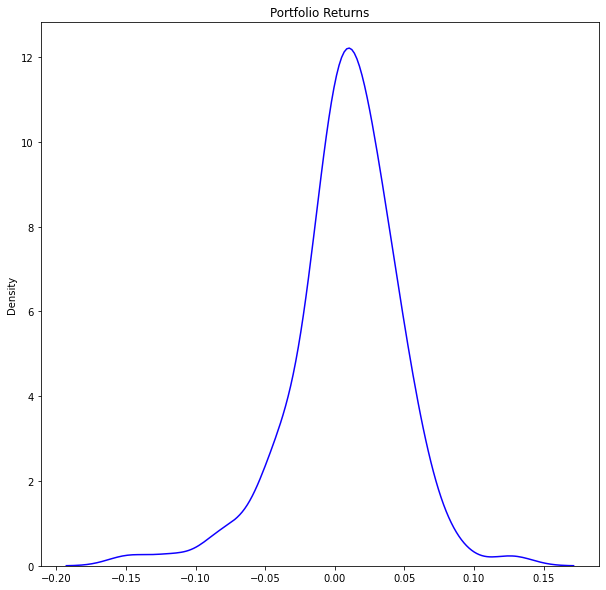

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Portfolio Returns')
sns.kdeplot(data=portfolio_returns, ax=ax, color='#0F00FF')

-----

In [29]:
discount_factor = np.cumprod(portfolio_returns+1)
discount_factor

Date
2011-03-30    1.041319
2011-04-13    1.030709
2011-04-28    1.042432
2011-05-12    1.031477
2011-05-26    0.985831
                ...   
2015-10-23    2.288566
2015-11-06    2.254742
2015-11-20    2.308202
2015-12-07    2.308982
2015-12-21    2.292316
Length: 120, dtype: float64

In [30]:
start = portfolio_positions.index[0]
end = portfolio_positions.index[-1]

In [31]:
market_portfolio_positions = _adj_close.loc[start:end,:].div(_adj_close.loc[start:end,:].sum(axis=1), axis=0)
market_trading_prices = _open.shift(-1).loc[market_portfolio_positions.index,:]
market_trading_returns = ((market_trading_prices - market_trading_prices.shift(1))/market_trading_prices.shift(1)).iloc[1:,:]
market_portfolio_returns = np.sum(market_trading_returns*market_portfolio_positions.shift(1).iloc[1:,:], axis=1)
market_discount_factor = np.cumprod(market_portfolio_returns+1)

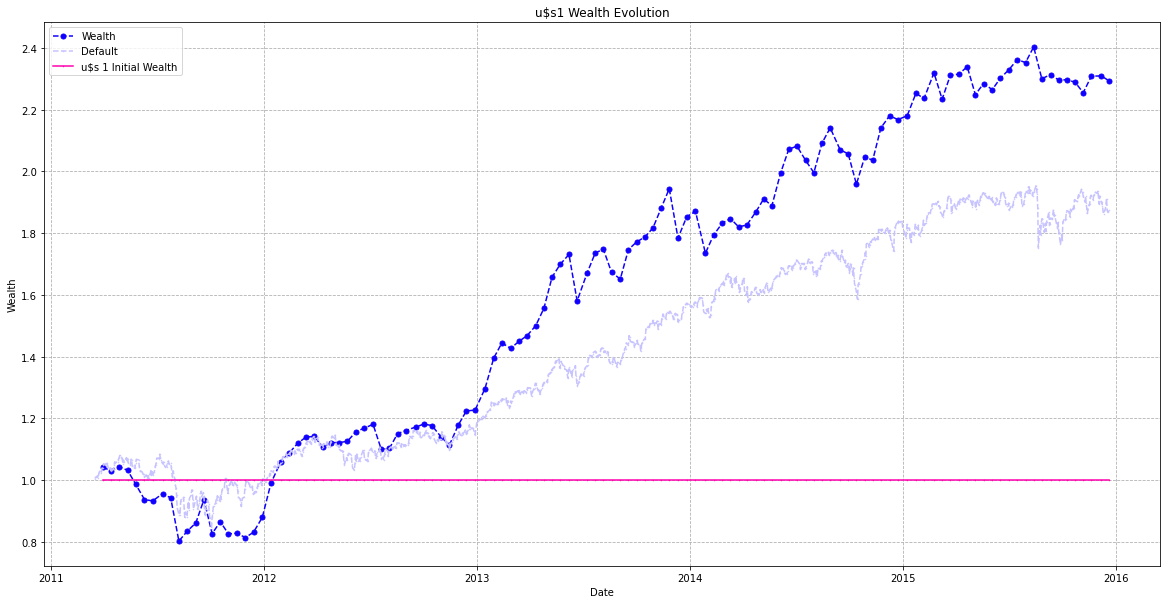

In [32]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('u$s1 Wealth Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.plot(discount_factor.index, discount_factor.values, marker='.', color='#0F00FF', markersize=10, linestyle='--', label='Wealth')
ax.plot(market_discount_factor.index, market_discount_factor.values, marker='.', color='#C7C3FF', markersize=1, linestyle='--', label='Default')
ax.plot(discount_factor.index, np.ones(discount_factor.shape), marker='.', color='#FF00AE', markersize=1, linestyle='-', label='u$s 1 Initial Wealth')
ax.legend()

In [33]:
portfolio_positions.to_csv('momentum_trading.csv')

-----

In [34]:
tickers = yf.Ticker("^GSPC")

sp500 = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
sp500 = sp500.loc[:,['Adj Close']]
sp500.head()

,Adj Close
Date,
2011-03-16 00:00:00-04:00,1256.880005
2011-03-17 00:00:00-04:00,1273.719971
2011-03-18 00:00:00-04:00,1279.209961
2011-03-21 00:00:00-04:00,1298.380005
2011-03-22 00:00:00-04:00,1293.770020


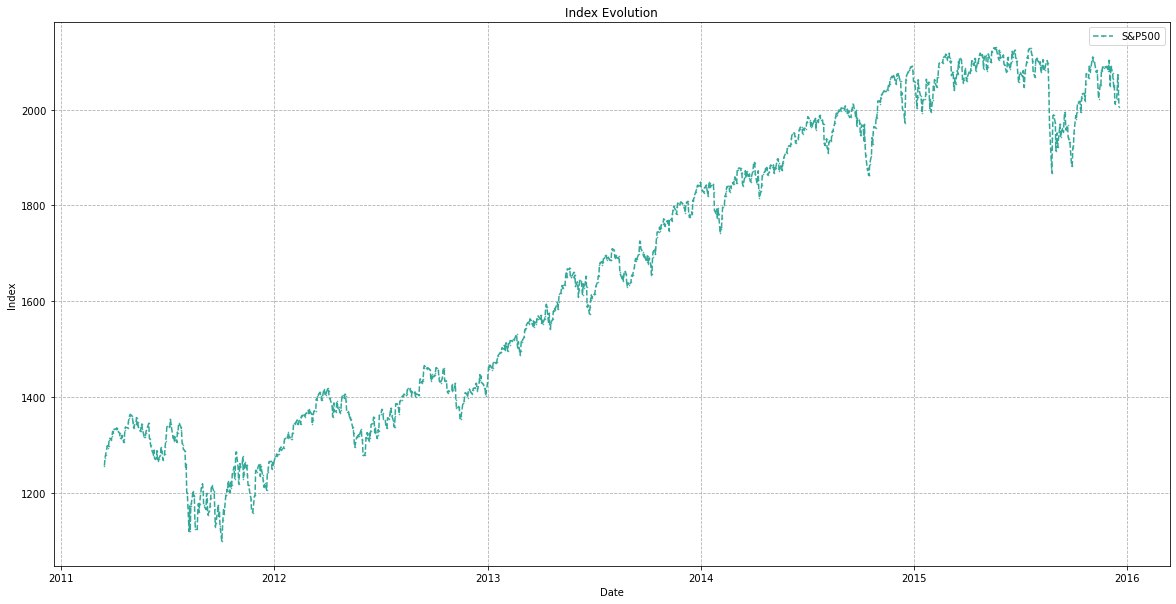

In [35]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('Index Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
ax.plot(sp500.index, sp500.loc[:,'Adj Close'].values, marker='.', color='#32A899', markersize=1, linestyle='--', label='S&P500')
ax.legend()